##

### Step 1: Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# set visualization styles
sns.set(style='whitegrid')



### Step 2: Load and Explore the Data

In [3]:
# Load the dataset
df = pd.read_excel('../data/Online Retail.xlsx')

#dataset shape
print("dataset shape:", df.shape)

#display first few rows
display(df.head())

dataset shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Explore the data

print("Dataset Information:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Number of duplicate rows: 5268


### Step 3:  Clean the Data

In [5]:
print("Rows before cleaning:", df.shape[0])

# remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# remove duplicates
df = df.drop_duplicates()

# Remove negative quantities(cancelled/returned items
df = df[df['Quantity'] > 0]

# Remove negative or zero prices(cancelled/returned items)
df = df[df['UnitPrice'] > 0]

print("Rows after cleaning:", df.shape[0])

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Convert CustomerID to an integer(from float)
df['CustomerID'] = df['CustomerID'].astype(int)

# Display cleaned data info
print("\nCleaned Dataset Information:")
print(df.info())







Rows before cleaning: 541909
Rows after cleaning: 392692

Cleaned Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
 8   TotalPrice   392692 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 30.0+ MB
None


### Step 4: Create RFM Features

* R - Recency: How recently did they buy? (Fewer days ago is better).
* F - Frequency: How often do they buy? (More times is better).
* M - Monetary: How much money do they spend? (More money is better).

In [6]:
#get the most recent date in the dataset
max_date = df['InvoiceDate'].max()
print("Most recent date in dataset:", max_date)

#calculate RFM for each customer
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                 # Monetary
}).reset_index()

#rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("\nTotal customers:" , len(rfm))

print("\nRFM Data:")
display(rfm.head())




Most recent date in dataset: 2011-12-09 12:50:00

Total customers: 4338

RFM Data:


,CustomerID,Recency,Frequency,Monetary
0,12346,325,1,77183.60
1,12347,1,7,4310.00
2,12348,74,4,1797.24
3,12349,18,1,1757.55
4,12350,309,1,334.40


### Step 5: Visualize RFM Distributions

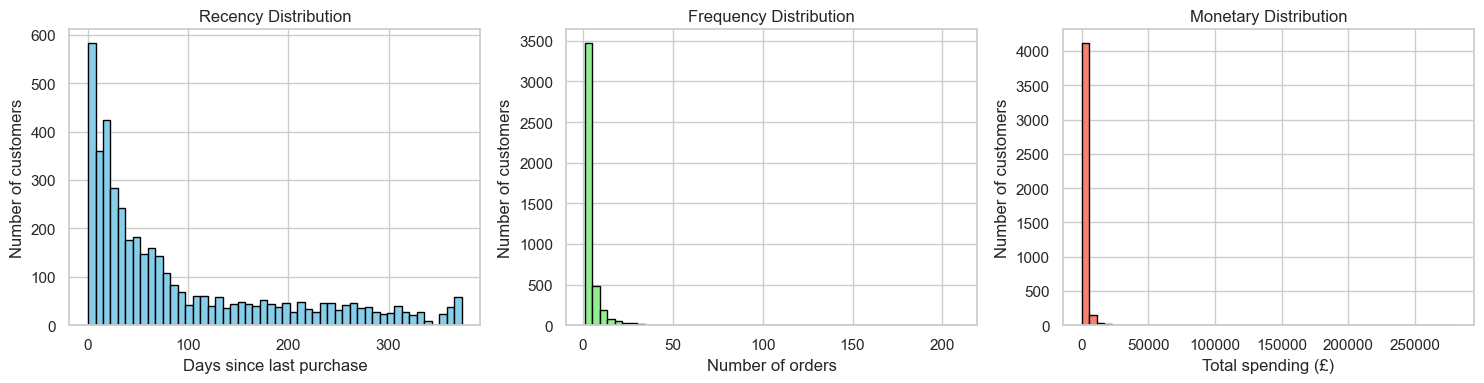

In [7]:
# Create charts to see the data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Recency chart
axes[0].hist(rfm['Recency'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Number of customers')

# Frequency chart
axes[1].hist(rfm['Frequency'], bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of orders')
axes[1].set_ylabel('Number of customers')

# Monetary chart
axes[2].hist(rfm['Monetary'], bins=50, color='salmon', edgecolor='black')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total spending (£)')
axes[2].set_ylabel('Number of customers')
plt.tight_layout()
plt.show()




### Step 6: Feature Scaling

In [8]:
# Select only R, F, M columns for clustering
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']].copy()

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

print(f"Scaled data shape: {rfm_scaled.shape}")

print("\nFirst 5 rows:")
print(rfm_scaled[:5])

Scaled data shape: (4338, 3)

First 5 rows:
[[ 2.33457414 -0.4250965   8.36301037]
 [-0.90534032  0.3544168   0.2516989 ]
 [-0.17535959 -0.03533985 -0.02798783]
 [-0.73534481 -0.4250965  -0.03240559]
 [ 2.17457836 -0.4250965  -0.19081155]]


### Step 7: Find Optimal Number of Clusters (k)
* Elbow Method - Plot a graph; look for the elbow (bend)​
* Silhouette Score -  Higher => better separated clusters

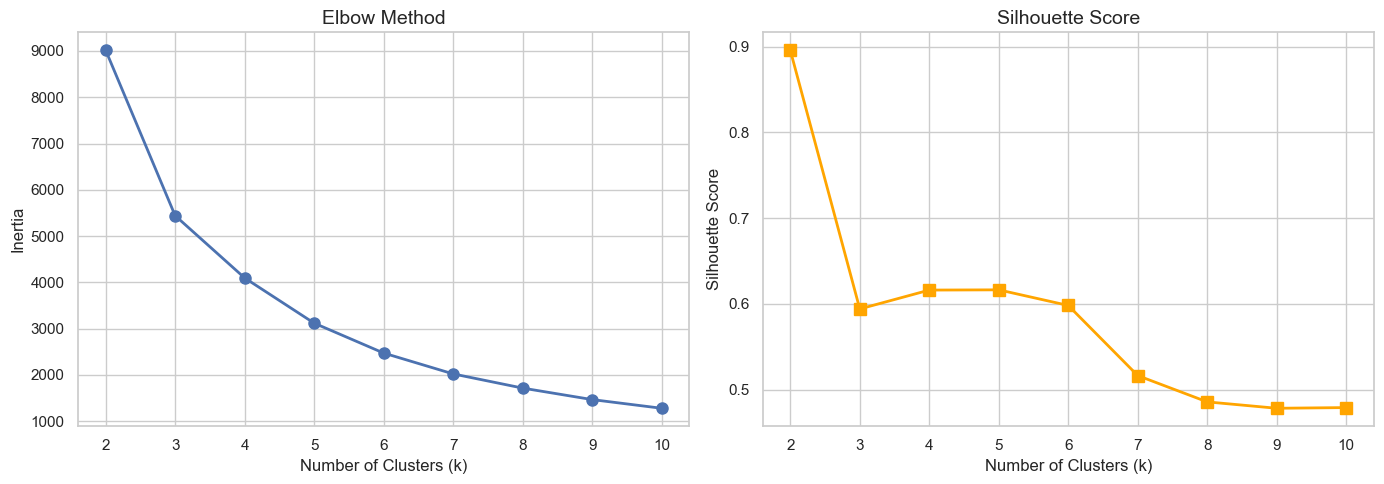

In [9]:
# Try different numbers of clusters (2 to 10)
inertias = [] #wcss
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    # Create model with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    
    # Calculate and store inertia (WCSS)
    inertias.append(kmeans.inertia_)

    # calculate and store silhouette score
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

# Create charts
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow chart
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method', fontsize=14)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].grid(True)

# Silhouette chart
axes[1].plot(K_range, silhouette_scores, marker='s', color='orange', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Score', fontsize=14)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].grid(True)
plt.tight_layout()
plt.show()

### Step 8:  Train the Final Model

* Based on the charts,let's pick **k=4** i.e four customer groups.

In [10]:
# Create the final model with 4 clusters
optimal_k = 4
kmeans_final = KMeans(n_clusters= optimal_k, random_state=42, n_init= 10)

# Fit the model 
kmeans_final.fit(rfm_scaled)

#getting cluster labels
rfm['Cluster'] = kmeans_final.labels_

# customers in each cluster
print("\nCustomers per cluster:")
print(rfm['Cluster'].value_counts().sort_index())

# Displaying  RFM data with cluster labels
display(rfm.head())


Customers per cluster:
Cluster
0    3054
1    1067
2      13
3     204
Name: count, dtype: int64


,CustomerID,Recency,Frequency,Monetary,Cluster
0,12346,325,1,77183.60,3
1,12347,1,7,4310.00,0
2,12348,74,4,1797.24,0
3,12349,18,1,1757.55,0
4,12350,309,1,334.40,1


### Step 9: Analyze and Name the Clusters

In [11]:
# Calculate average RFM for each cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

print("\nCluster Summary (Average RFM values):")
print(cluster_summary.round(2))

#naming clusters based on RFM values
cluster_names = {
    0: 'Potential Loyalists',  # Mid R, Low F, Mid M
    1: 'At Risk Customers' ,     # High R, Low F, Low M
    2: 'VIP Customers'  ,     # Low R, High F, High M
    3: 'Loyal Customers'    # Low R, High F, Mid M
}


# Add cluster names to dataframe
rfm['Cluster_Name'] = rfm['Cluster'].map(cluster_names)

# Displaying  RFM data with cluste names
display(rfm.head(5))




Cluster Summary (Average RFM values):
         Recency  Frequency   Monetary
Cluster                               
0          42.70       3.68    1353.63
1         247.08       1.55     478.85
2           6.38      82.54  127187.96
3          14.50      22.33   12690.50


,CustomerID,Recency,Frequency,Monetary,Cluster,Cluster_Name
0,12346,325,1,77183.60,3,Loyal Customers
1,12347,1,7,4310.00,0,Potential Loyalists
2,12348,74,4,1797.24,0,Potential Loyalists
3,12349,18,1,1757.55,0,Potential Loyalists
4,12350,309,1,334.40,1,At Risk Customers


### Step 10: Visualize Clusters with PCA

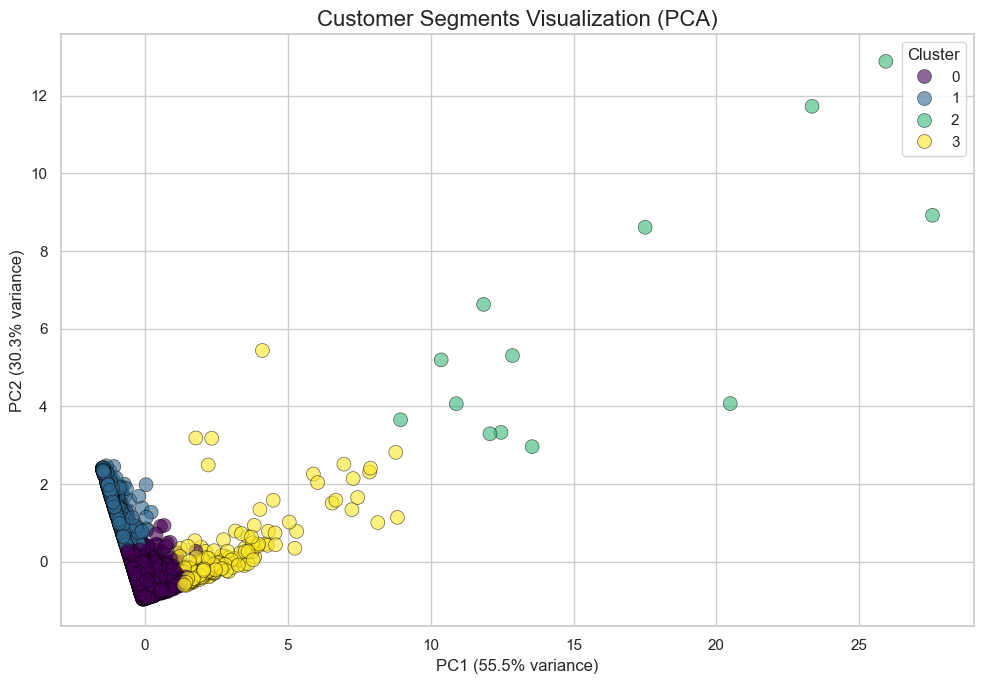

Total variance explained: 85.7%


In [12]:
# Apply PCA to reduce to 2 dimensions
pca = PCA(n_components=2, random_state=42)
rfm_pca = pca.fit_transform(rfm_scaled)

#Put the 2 new PCA features into a dataframe
pca_df = pd.DataFrame(rfm_pca, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster']  

#create sns scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df,
                x='PC1',
                y='PC2',
                hue='Cluster',              
                palette='viridis',          
                s=100,                      
                alpha=0.6,
                edgecolor='black',
                linewidth=0.5
)
plt.title('Customer Segments Visualization (PCA)', fontsize=16)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout() 
plt.show()


print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.1%}")





### Step 11: Create Box Plots for Each Feature

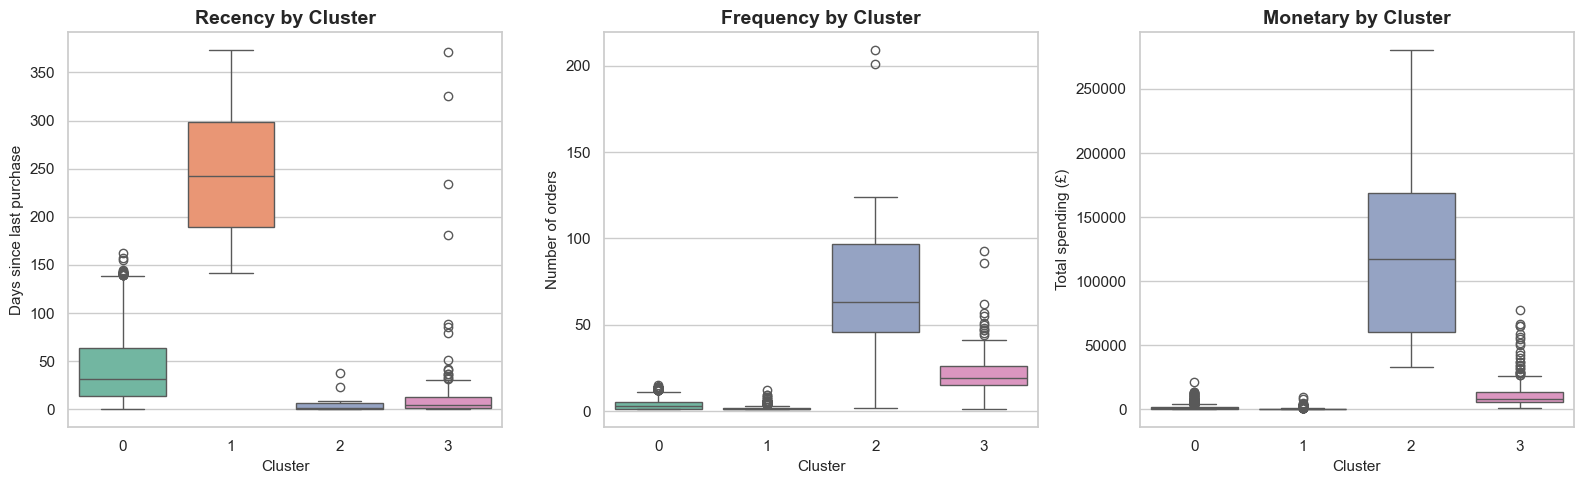

In [13]:
# Box plots for each RFM feature by cluster
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Recency
sns.boxplot(data=rfm, x='Cluster', y='Recency', hue='Cluster', palette='Set2', ax=axes[0], legend=False)
axes[0].set_title('Recency by Cluster', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Cluster', fontsize=11)
axes[0].set_ylabel('Days since last purchase', fontsize=11)

# Frequency
sns.boxplot(data=rfm, x='Cluster', y='Frequency', hue='Cluster', palette='Set2', ax=axes[1], legend=False)
axes[1].set_title('Frequency by Cluster', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cluster', fontsize=11)
axes[1].set_ylabel('Number of orders', fontsize=11)

# Monetary
sns.boxplot(data=rfm, x='Cluster', y='Monetary', hue='Cluster', palette='Set2', ax=axes[2], legend=False)
axes[2].set_title('Monetary by Cluster', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Cluster', fontsize=11)
axes[2].set_ylabel('Total spending (£)', fontsize=11)

plt.tight_layout()
plt.show()

### Step 12: Save the Model 

In [14]:
import pickle

# Save the model
with open('../models/kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans_final, file)


# Save the scaler
with open('../models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save cluster names
with open('../models/cluster_names.pkl', 'wb') as file:
    pickle.dump(cluster_names, file)

print("Model, scaler, and cluster names saved successfully")

Model, scaler, and cluster names saved successfully
